In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [2]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [3]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [4]:
def bonos_dbAlgebra(n,cn):

    niu_data = pd.DataFrame()

    bonos = "SELECT TOP ("+ str(n) +") Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, NemotecnicoBono AS Nemotecnico, RiesgoInt FROM (SELECT * FROM (SELECT Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, Nemotecnico AS NemotecnicoBono FROM [dbAlgebra].[dbo].[TdNemoRF]) AS bono JOIN (SELECT * FROM [dbPortFolio].[dbo].[TdPlanvitalCartera]) AS planvital ON bono.FechaEmision > '20190101' AND bono.NemotecnicoBono = planvital.Nemotecnico) AS A JOIN (SELECT DISTINCT Nemotecnico, RiesgoLVA AS RiesgoInt FROM [dbAlgebra].[dbo].[TdRiesgoLva]) AS B ON A.NemotecnicoBono = B.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)

    moneda = []
    base1 = []
    base2 = []
    tabla = []
    fechaemi = []
    nemotecnico = []
    riesgo = []
    for i in range(np.size(bonos, 0)):

        if bonos["Nemotecnico"][i] in nemotecnico: continue

        if bonos["RiesgoInt"][i] in riesgo : continue

        moneda.append(bonos["Moneda"][i])
        base1.append(bonos["Base1"][i])
        base2.append(bonos["Base2"][i])
        tabla.append(bonos["TablaDesarrollo"][i])
        fechaemi.append(bonos["FechaEmision"][i])
        nemotecnico.append(bonos["Nemotecnico"][i])
        riesgo.append(bonos["RiesgoInt"][i])

    niu_data["Moneda"] = moneda
    niu_data["Base1"] = base1
    niu_data["Base2"] = base2
    niu_data["TablaDesarrollo"] = tabla
    niu_data["FechaEmision"] = fechaemi
    niu_data["Nemotecnico"] = nemotecnico
    niu_data["RiesgoInt"] = riesgo


    return niu_data

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {-1: "AAA", 1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
bonos = ajustes(bonos_dbAlgebra(500,cn))
bonos

,Moneda,Base1,Base2,TablaDesarrollo,FechaEmision,Nemotecnico,RiesgoInt,Convencion,Riesgo
0,UF,ACT,365,"1#01-08-2019#1,25#0#100#1,25|2#01-02-2020#1,25...",2019-02-01,BBIC750219,3,ACT/365,AA
1,UF,ACT,365,"1#01-03-2020#0,3245#0#100#0,3245|2#01-09-2020#...",2019-09-01,BCSSA-C,2,ACT/365,AA
2,UF,ACT,365,"1#01-09-2019#1,3163#0#100#1,3163|2#01-03-2020#...",2019-03-01,BFFCC-AD,1,ACT/365,AAA
3,UF,ACT,365,"1#30-10-2019#1,094#0#100#1,094|2#30-04-2020#1,...",2019-04-30,BVIAS-A,4,ACT/365,AA
4,UF,ACT,365,"1#01-12-2019#0,8464#0#100#0,8464|2#01-06-2020#...",2019-06-01,BCMPC-O,-1,ACT/365,AAA
5,UF,ACT,365,"1#15-10-2019#1,7841#0#100#1,7841|2#15-04-2020#...",2019-04-15,BLATM-E,8,ACT/365,BBB


In [7]:
bonos["Riesgo"].values

array(['AA', 'AA', 'AAA', 'AA', 'AAA', 'BBB'], dtype=object)

In [8]:
derivados = derivados_dBDerivados(2, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,4.331011e+07,4.293818e+07,CLP,CLP
1,1368,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.549401e+07,3.494116e+07,CLP,CLP
2,1368,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,4.784481e+07,4.665317e+07,CLP,CLP
3,1368,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.042244e+09,4.875468e+09,CLP,CLP
4,1368,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.620869e+07,CLP,CLP
5,1368,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.635001e+07,CLP,CLP
6,1368,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.541630e+07,CLP,CLP
7,1368,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.870324e+09,CLP,CLP


In [9]:
arreglo_acciones = ["AESGENER", "AGUAS-A", "ANDINA-A", "ANDINA-B", "DE000DWS2D90", "ANTARCHILE"]
arreglo_fondos = ["A", "A", "A", "A", "A", "A"]


acciones = historico(arreglo_acciones, arreglo_fondos, 60)
acciones


,Moneda,Nombre,Nemotecnico,Inversion,Historico
0,CLP,AESGENER,AESGENER,1.743959e+09,"[[0, 0.0025957870479299534, -0.007433469137058..."
1,CLP,AGUAS-A,AGUAS-A,1.566402e+07,"[[0, 0.003305297208302039, 0.03566773260328181..."
2,CLP,ANDINA-A,ANDINA-A,1.492768e+08,"[[0, 0.00034804011961498776, 0.018505998119275..."
3,CLP,ANDINA-B,ANDINA-B,1.098975e+09,"[[0, 0.005746838657845234, 0.0175731917247771,..."
4,CLP,DE000DWS2D90,DE000DWS2D90,1.258575e+10,"[[0, -0.011984448831005957, -0.025391621016988..."
5,CLP,ANTARCHILE,ANTARCHILE,1.567905e+08,"[[0, 0.009876696995043567, 0.00310408270978682..."


.767029    0.765514    0.767551   
CLP#3201#AA    0.739760    0.761587    0.760240    0.758782    0.760649   
CLP#3366#AA    0.729729    0.752043    0.750937    0.749553    0.751218   
CLP#3530#AA    0.728916    0.751285    0.750190    0.748808    0.750489   
CLP#3712#AA    0.727984    0.750413    0.749330    0.747949    0.749651   

             CLP#484#AA  CLP#569#AA  CLP#648#AA  CLP#679#AA  CLP#750#AA  ...  \
CLP#123#AA     0.980059    0.968455    0.946494    0.935433    0.919253  ...   
CLP#209#AA     0.993513    0.976363    0.948899    0.935723    0.916967  ...   
CLP#288#AA     0.991545    0.971341    0.940995    0.926744    0.906659  ...   
CLP#319#AA     0.990380    0.969149    0.937844    0.923238    0.902710  ...   
CLP#390#AA     0.993374    0.974674    0.945721    0.931985    0.912533  ...   
CLP#484#AA     1.000000    0.993915    0.976796    0.967458    0.953483  ...   
CLP#569#AA     0.993915    1.000000    0.994442    0.989440    0.980884  ...   
CLP#648#AA     0.976796 

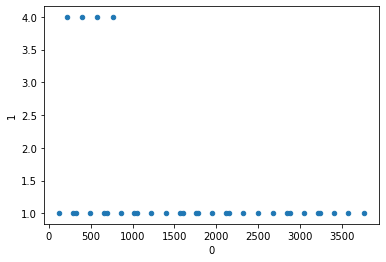

In [10]:
cartera = Cartera(acciones, bonos.head(2), derivados, "CLP", datetime.date(2019, 10, 14), cn)

In [11]:
cartera.get_diccionario_niveles()

{1: {('Renta Variable Nacional Acciones',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.56790546e+08]),
  ('Renta Variable Extranjera',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.25857487e+10, 0.00000000e+00]),
  ('Renta Fija Nacional ',
   'Bono',
   'AA'): array([1.04316666e+00, 1.99659078e-01, 6.48915831e-02, 6.01186180e-01,
         5.34901735e-01, 6.04365834e-02, 7.44003129e-02, 6.18987607e-02,
         1.82399683e-01, 1.82787969e-01, 9.00064685e-03, 5.12489462e-02,
         3.87118163e-02, 1.30816017e-02, 2.95585554e-02, 1.59470878e-02,
         1.63526647e-03, 2.28544086e-03, 5.40574646e-04, 4.53547849e-04,
         1.35433272e-03, 5.36359715e-05, 1.16259081e-04, 2.55766759e-04,
         1.30687119e-04, 5.79448548e-05, 2.73521355e-06, 3.55515923e-05,
         1.43044969e-05, 9.86074992e-07, 1.03858231e-04, 1.70731196e-04,
         7.65125500e-05]),
  ('Derivados

In [12]:
print(cartera.get_historicos_totales())

CLP#123#AA  CLP#209#AA  CLP#288#AA  CLP#319#AA  CLP#390#AA  CLP#484#AA  \
0     0.996628    0.994250    0.992048    0.991181    0.989184    0.986523   
1     0.996628    0.994248    0.992046    0.991178    0.989180    0.986516   
2     0.996628    0.994248    0.992044    0.991176    0.989177    0.986511   
3     0.996604    0.994179    0.991914    0.991015    0.988936    0.986139   
4     0.996604    0.994180    0.991914    0.991016    0.988937    0.986141   
5     0.996604    0.994180    0.991914    0.991016    0.988938    0.986141   
6     0.996628    0.994248    0.992044    0.991176    0.989177    0.986512   
7     0.996636    0.994272    0.992091    0.991234    0.989263    0.986645   
8     0.996637    0.994273    0.992093    0.991235    0.989266    0.986649   
9     0.996643    0.994292    0.992128    0.991279    0.989331    0.986749   
10    0.996630    0.994253    0.992055    0.991189    0.989196    0.986541   
11    0.996638    0.994276    0.992099    0.991242    0.989277    0.

In [13]:
print(cartera.get_retornos_totales())

CLP#123#AA    CLP#209#AA  CLP#288#AA  CLP#319#AA  CLP#390#AA  \
0   0.000000e+00  0.000000e+00    0.000000    0.000000    0.000000   
1   9.619320e-05  9.538585e-05    0.000094    0.000094    0.000092   
2   9.629729e-05  9.570363e-05    0.000095    0.000094    0.000093   
3   7.287637e-05  2.798953e-05   -0.000035   -0.000065   -0.000146   
4   2.902020e-04  2.903706e-04    0.000291    0.000291    0.000291   
5   9.659027e-05  9.663713e-05    0.000097    0.000097    0.000097   
6   1.202088e-04  1.649546e-04    0.000228    0.000258    0.000339   
7   1.051479e-04  1.213380e-04    0.000144    0.000155    0.000184   
8   9.715949e-05  9.765139e-05    0.000098    0.000099    0.000100   
9   2.964482e-04  3.087124e-04    0.000326    0.000334    0.000356   
10  8.302442e-05  5.769246e-05    0.000022    0.000006   -0.000040   
11  1.045046e-04  1.195816e-04    0.000141    0.000151    0.000178   
12  1.008661e-04  1.077480e-04    0.000117    0.000122    0.000134   
13  9.279988e-05  8.590318

In [14]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

0.003106468419332642


In [15]:
cartera.get_covarianza()

,CLP#123#AA,CLP#209#AA,CLP#288#AA,CLP#319#AA,CLP#390#AA,CLP#484#AA,CLP#569#AA,CLP#648#AA,CLP#679#AA,CLP#750#AA,...,CLP#3201,CLP#3366,CLP#3530,CLP#3712,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#123#AA,4.882471e-07,1.540113e-06,0.000003,0.000004,0.000006,8.438687e-06,0.000010,0.000013,0.000013,0.000015,...,6.593732e-07,6.541097e-07,6.335600e-07,6.313089e-07,-0.000002,1.124964e-07,-0.000001,0.000001,-0.000002,9.848458e-07
CLP#209#AA,1.540113e-06,4.968618e-06,0.000011,0.000014,0.000021,2.728941e-05,0.000034,0.000040,0.000043,0.000048,...,1.724597e-06,1.696734e-06,1.611597e-06,1.583375e-06,-0.000005,4.618913e-07,-0.000003,0.000005,-0.000005,3.667533e-06
CLP#288#AA,3.338380e-06,1.083945e-05,0.000024,0.000031,0.000046,5.947785e-05,0.000073,0.000087,0.000093,0.000105,...,3.362034e-06,3.286808e-06,3.075500e-06,2.987774e-06,-0.000011,1.192947e-06,-0.000004,0.000013,-0.000011,7.992689e-06
CLP#319#AA,4.312372e-06,1.402246e-05,0.000031,0.000040,0.000060,7.689961e-05,0.000094,0.000112,0.000119,0.000135,...,4.186834e-06,4.083099e-06,3.798251e-06,3.673289e-06,-0.000014,1.634033e-06,-0.000005,0.000017,-0.000015,1.025164e-05
CLP#390#AA,6.477339e-06,2.106080e-05,0.000046,0.000060,0.000090,1.158222e-04,0.000142,0.000169,0.000181,0.000205,...,6.834553e-06,6.693339e-06,6.298117e-06,6.143991e-06,-0.000021,1.933963e-06,-0.000008,0.000024,-0.000023,1.581827e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,1.124964e-07,4.618913e-07,0.000001,0.000002,0.000002,-4.694533e-07,-0.000004,-0.000009,-0.000012,-0.000016,...,-4.223066e-07,-7.272378e-07,-6.317112e-07,-5.908509e-07,-0.000012,9.993954e-05,0.000039,0.000058,0.000016,3.732992e-05
ANDINA-A,-1.452608e-06,-2.609163e-06,-0.000004,-0.000005,-0.000008,-2.107247e-05,-0.000038,-0.000061,-0.000072,-0.000091,...,-1.935215e-05,-1.716709e-05,-1.543352e-05,-1.451492e-05,0.000015,3.862051e-05,0.000418,0.000084,0.000051,8.513652e-05
ANDINA-B,1.250932e-06,5.340430e-06,0.000013,0.000017,0.000024,2.552099e-05,0.000024,0.000020,0.000017,0.000014,...,1.358486e-05,1.287562e-05,1.293063e-05,1.314854e-05,-0.000003,5.782428e-05,0.000084,0.000433,0.000008,8.386062e-05
DE000DWS2D90,-1.583266e-06,-5.247129e-06,-0.000011,-0.000015,-0.000023,-3.093174e-05,-0.000040,-0.000050,-0.000055,-0.000063,...,-1.999634e-06,-9.104085e-07,3.030896e-07,1.144122e-06,-0.000006,1.555668e-05,0.000051,0.000008,0.000063,9.187219e-06


In [16]:
cartera.get_correlacion()

,CLP#123#AA,CLP#209#AA,CLP#288#AA,CLP#319#AA,CLP#390#AA,CLP#484#AA,CLP#569#AA,CLP#648#AA,CLP#679#AA,CLP#750#AA,...,CLP#3201,CLP#3366,CLP#3530,CLP#3712,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#123#AA,1.000000,0.988814,0.981468,0.979439,0.979717,0.980059,0.968455,0.946494,0.935433,0.919253,...,0.180258,0.173138,0.161090,0.153289,-0.177527,0.016105,-0.101698,0.086041,-0.284787,0.114413
CLP#209#AA,0.988814,1.000000,0.998964,0.998360,0.998576,0.993513,0.976363,0.948899,0.935723,0.916967,...,0.147793,0.140785,0.128451,0.120518,-0.171474,0.020728,-0.057262,0.115147,-0.295863,0.133563
CLP#288#AA,0.981468,0.998964,1.000000,0.999926,0.999778,0.991545,0.971341,0.940995,0.926744,0.906659,...,0.131930,0.124881,0.112247,0.104135,-0.165236,0.024514,-0.041165,0.125036,-0.296369,0.133285
CLP#319#AA,0.979439,0.998360,0.999926,1.000000,0.999693,0.990380,0.969149,0.937844,0.923238,0.902710,...,0.126926,0.119848,0.107094,0.098906,-0.162910,0.025940,-0.036734,0.127723,-0.296021,0.132070
CLP#390#AA,0.979717,0.998576,0.999778,0.999693,1.000000,0.993374,0.974674,0.945721,0.931985,0.912533,...,0.137980,0.130836,0.118259,0.110170,-0.168948,0.020446,-0.043687,0.123810,-0.300591,0.135710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,0.016105,0.020728,0.024514,0.025940,0.020446,-0.003811,-0.027152,-0.049269,-0.057548,-0.067274,...,-0.008069,-0.013455,-0.011227,-0.010028,-0.088274,1.000000,0.188988,0.277994,0.195585,0.303122
ANDINA-A,-0.101698,-0.057262,-0.041165,-0.036734,-0.043687,-0.083656,-0.121987,-0.158058,-0.171482,-0.186969,...,-0.180841,-0.155325,-0.134137,-0.120472,0.056380,0.188988,1.000000,0.197562,0.311225,0.338087
ANDINA-B,0.086041,0.115147,0.125036,0.127723,0.123810,0.099538,0.074696,0.049893,0.040296,0.029065,...,0.124719,0.114452,0.110411,0.107216,-0.010407,0.277994,0.197562,1.000000,0.049990,0.327175
DE000DWS2D90,-0.284787,-0.295863,-0.296369,-0.296021,-0.300591,-0.315492,-0.326368,-0.333511,-0.335370,-0.335800,...,-0.048009,-0.021163,0.006768,0.024398,-0.060160,0.195585,0.311225,0.049990,1.000000,0.093734


In [17]:
cartera.get_volatilidad_niveles()

{1: {('Renta Variable Nacional Acciones', 'Accion'): 0.012318889593453,
  ('Renta Variable Extranjera', 'Accion'): 0.00795634184685601,
  ('Renta Fija Nacional ', 'Bono', 'AA'): 0.006113335767026635,
  ('Derivados', 'Derivado'): 0.0006440867405715104},
 2: {('Acciones Electricas', 'Accion'): 0.013447928815222773,
  ('Acciones Servicios', 'Accion'): 0.00999697675731327,
  ('Acciones Industrial', 'Accion'): 0.02080684545966357,
  ('Equities Europe', 'Accion'): 0.00795634184685601,
  ('Acciones Recursos Naturales', 'Accion'): 0.012318889593453,
  ('Bonos Financieros', 'Bono', 'AA'): 0.0075401598272801275,
  ('Derivados FWD Inversión', 'Derivado'): 0.0006440867405865438}}

In [18]:
cartera.var_i_porcentual_dinero()

,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE,BBIC750219,BCSSA-C,BCINO UF 200709_A
0,0.008149,0.000054,0.00106,0.007945,0.034795,0.000671,7.158905e-12,2.190399e-12,0.004466


In [19]:
cartera.var_i_porcentual_dinero(cartera.get_monto())

,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE,BBIC750219,BCSSA-C,BCINO UF 200709_A
0,3.722990e+08,2.485835e+06,4.844043e+07,3.629898e+08,1.589618e+09,3.066138e+07,0.327058,0.100069,2.040484e+08
